In [1]:
import glob
import os
import pandas as pd
import seaborn as snsß
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from algos.alg_fpd import Fpd
from algos.alg_fpd_predictor import FpdPredictor
import numpy as np
import random
import json
import tqdm
from shapely.geometry import shape
from collections import defaultdict

100%|██████████| 16000/16000 [00:04<00:00, 3778.96it/s]


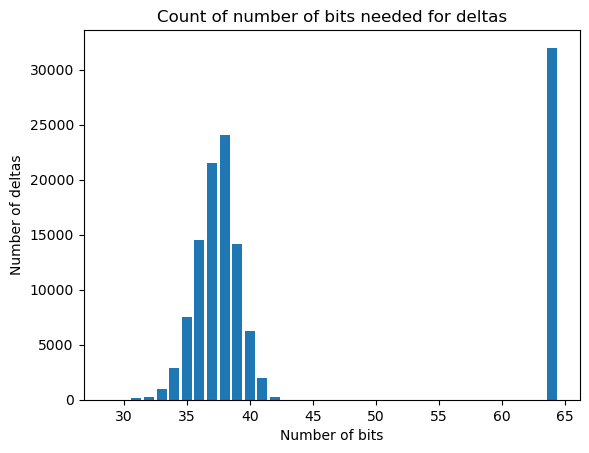

In [2]:
fpd = Fpd()
DATASET_PATH = "data/lund_building_highway.json"
#DATASET_PATH = "data/world.json"
NBR_ITER = 16000


SEED = 123 # If we want to enforce the same ordering and indexes for multiple runs, else None
random.seed(SEED) # Init random

# Extract the nested feature attribute of the geo_json file containing the geometries
with open(DATASET_PATH, 'r') as f:
    data = json.loads(f.read())
file_df: pd.DataFrame = pd.json_normalize(data, record_path=['features'])
# Create a dataframe suitable for the WKT format for easy convertion to shapely objects
df = pd.DataFrame(
    {'type': file_df['geometry.type'], 'coordinates': file_df['geometry.coordinates']})

max_idx = len(df) - 1
unary_idxs = [random.randint(0, max_idx) for i in range(NBR_ITER)] # Generate list of indexes to query on
random.seed(SEED) # Reset random

tot_bit_count = defaultdict(int)
total_deltas = []
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    _, bit_count, deltas = fpd.calculate_delta_size(shape(df.iloc[idx]), True)
    total_deltas += deltas
    for bit_count_key in bit_count:
        tot_bit_count[bit_count_key] += bit_count[bit_count_key]
plt.bar(tot_bit_count.keys(), tot_bit_count.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()
total_deltas = np.array(total_deltas)

Percentage of total deltas within filtered 1.0
Percentage of total deltas (but removed excessive values) within filtered 3.95659375


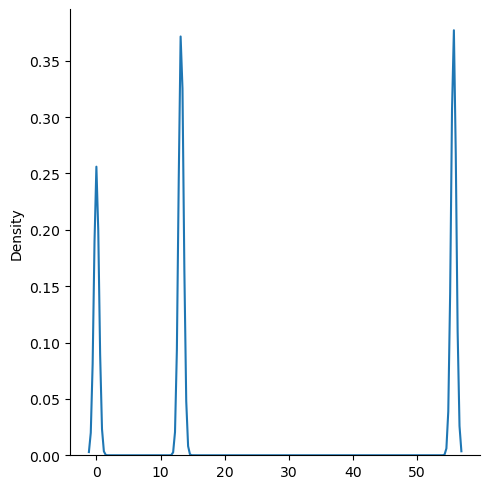

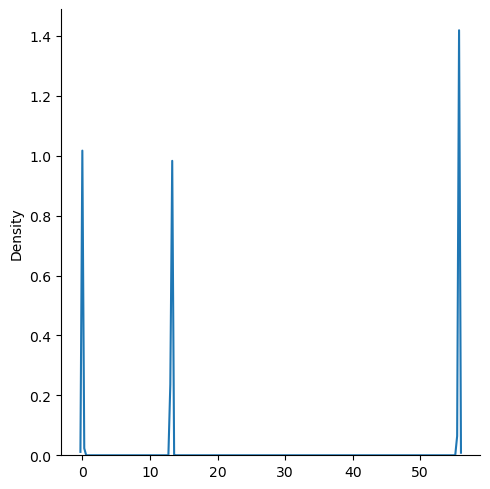

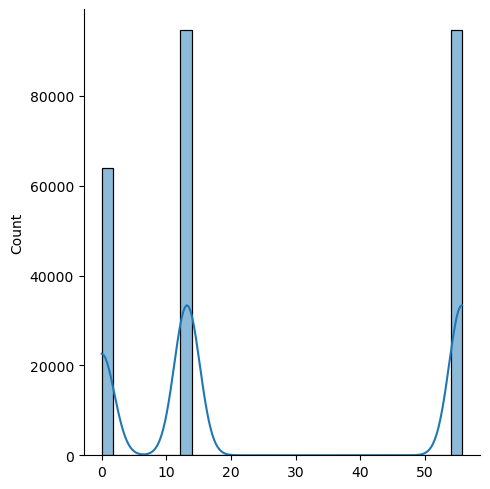

In [3]:
sns.displot(total_deltas, kind="kde", bw_adjust=.2)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLITER_THRESHOLD = 2.5

filtered = np.array(total_deltas)
filtered = filtered[~is_outlier(filtered, thresh=OUTLITER_THRESHOLD)]
sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total deltas within filtered", len(filtered) / len(total_deltas))
print("Percentage of total deltas (but removed excessive values) within filtered", len(filtered) / len(total_deltas[total_deltas < 10]))
print(total_deltas)
